# Capstone Project: 

### 2016 U.S. POTUS Primary Election

In [32]:
import pandas as pd
#pd.set_option('display.max_rows', 1300)
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sns
import sqlite3
import time
from sklearn.grid_search import GridSearchCV

from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score
from sklearn.tree import export_graphviz

from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext sql
%sql sqlite:///database.sqlite
try:    
    db = sqlite3.connect('database.sqlite')
    c = db.cursor()
    print "Successfully connected to the database"
except IntegrityError:
    print"Did not successfully connect to database"

Successfully connected to the database


## Explore the Data:

In [ ]:
#Primary Results:
#%sql SELECT * FROM primary_results
%sql ALTER TABLE primary_results ADD COLUMN county_state TEXT;
%sql UPDATE primary_results SET county_state = (county || "_" || state_abbreviation);
%sql UPDATE primary_results SET candidate = Replace(candidate,' ','_');

#Create Republican Table:
%sql CREATE TABLE Republicans AS SELECT * FROM primary_results;
%sql DELETE FROM Republicans WHERE(party ='Democrat') 

#Create Democrat Table:
%sql CREATE TABLE Democrats AS SELECT * FROM primary_results;
%sql DELETE FROM Democrats WHERE(party ='Republican') 

#Update County Facts Table:
%sql UPDATE county_facts SET state_abbreviation = NULL WHERE state_abbreviation = '';
%sql DELETE FROM county_facts WHERE state_abbreviation IS NULL;
%sql ALTER TABLE county_facts ADD COLUMN county_state TEXT;
%sql UPDATE county_facts SET area_name = SUBSTR(area_name,1, LENGTH(area_name)-7);
%sql UPDATE county_facts SET county_state = (area_name || "_" || state_abbreviation);
%sql UPDATE county_facts SET county_state = REPLACE(county_state,'"','');

#Output County_Facts_Description as CSV file (.mode csv)
#%sql .output county_facts_dict.csv # command in terminal

In [3]:
# Generate Dataframe
df_primary_results = pd.read_sql_query('SELECT * FROM primary_results', db) #Primary Results 
df_county_facts = pd.read_sql_query('SELECT * FROM county_facts',db) #County Facts
df_republicans = pd.read_sql_query('SELECT * FROM Republicans',db) # Republican Table
df_democrats = pd.read_sql_query('SELECT * FROM Democrats', db) # Democrat Table

#County Facts Dictionary:
df_county_facts_dictionary = pd.read_sql_query('SELECT * FROM county_facts_dictionary ',db)

In [4]:
# Primary results
df_primary_results.head()

state state_abbreviation   county  fips       party     candidate  votes  \
0  Alabama                 AL  Autauga  1001  Republican  Donald_Trump   5387   
1  Alabama                 AL  Autauga  1001  Republican      Ted_Cruz   2482   
2  Alabama                 AL  Autauga  1001  Republican   Marco_Rubio   1785   
3  Alabama                 AL  Autauga  1001  Republican    Ben_Carson   1764   
4  Alabama                 AL  Autauga  1001  Republican   John_Kasich    421   

   fraction_votes county_state  
0           0.445   Autauga_AL  
1           0.205   Autauga_AL  
2           0.148   Autauga_AL  
3           0.146   Autauga_AL  
4           0.035   Autauga_AL

In [5]:
# County Facts data
df_county_facts.head()

fips area_name state_abbreviation  PST045214  PST040210  PST120214  \
0  1001                           AL      55395      54571        1.5   
1  1003                           AL     200111     182265        9.8   
2  1005                           AL      26887      27457       -2.1   
3  1007                           AL      22506      22919       -1.8   
4  1009                           AL      57719      57322        0.7   

   POP010210  AGE135214  AGE295214  AGE775214      ...       SBO015207  \
0      54571        6.0       25.2       13.8      ...            31.7   
1     182265        5.6       22.2       18.7      ...            27.3   
2      27457        5.7       21.2       16.5      ...            27.0   
3      22915        5.3       21.0       14.8      ...             0.0   
4      57322        6.1       23.6       17.0      ...            23.2   

   MAN450207  WTN220207  RTN130207  RTN131207  AFN120207  BPS030214  \
0          0          0     598175      12003      88157        131   
1    1410273          0    2966489      17166     436955       1384   
2          0          0     188337       6334          0          8   
3          0          0     124707       5804      10757         19   
4     341544          0     319700       5622      20941          3   

   LND110210  POP060210  county_state  
0     594.44       91.8           _AL  
1    1589.78      114.6           _AL  
2     884.88       31.0           _AL  
3     622.58       36.8           _AL  
4     644.78       88.9           _AL  

[5 rows x 55 columns]

In [6]:
#shape of tables:
prim = df_primary_results.shape[0]
rep = df_republicans.shape[0]
dem = df_democrats.shape[0]
print "Primary Results..."
print "Total Number of Elements = {}; Republican: {}, Democrat :{}".format(prim,rep,dem)
print "Number of Features =", df_primary_results.shape[1]

#County Facts (shape):
print "\nCounty Facts..."
print "Total Number of Elements =", df_county_facts.shape[0]
print "Number of Features =", df_county_facts.shape[1] -4


Primary Results...
Total Number of Elements = 13212; Republican: 9152, Democrat :4060
Number of Features = 9

County Facts...
Total Number of Elements = 3143
Number of Features = 51


## Primary Results:

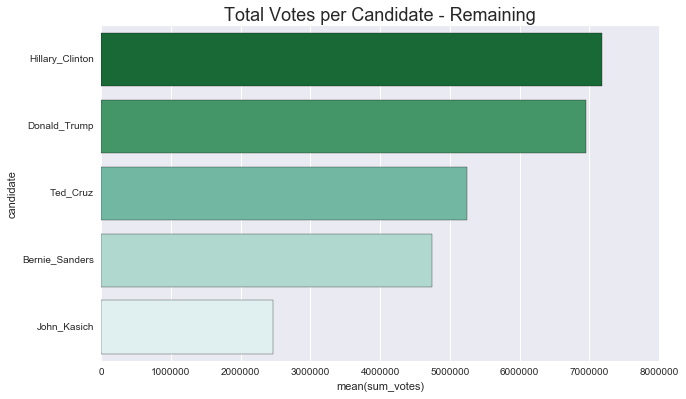

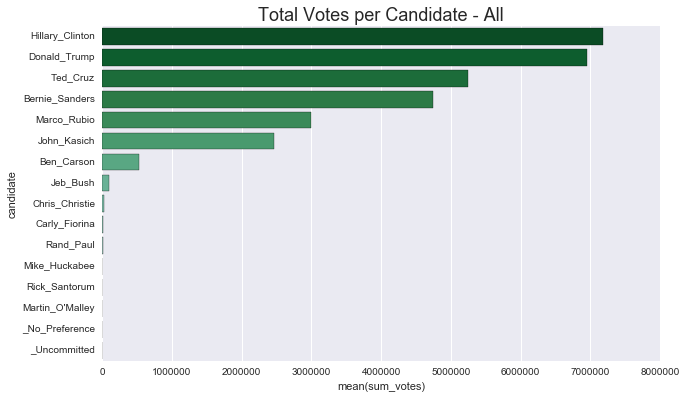

In [7]:
votes_sum = pd.read_sql_query('SELECT candidate, party, sum(votes) as sum_votes FROM primary_results GROUP BY candidate, party ORDER BY sum_votes desc, party;',db)
to_del = votes_sum.loc[votes_sum['candidate'].isin(['Jeb_Bush', 'Ben_Carson','Rand_Paul','Chris_Christie','Carly_Fiorina','Rick_Santorum','Mike_Huckabee',"Martin_O'Malley","Marco_Rubio","_No_Preference","_Uncommitted"])].index.tolist()
votes = votes_sum.drop(to_del)

#Plots
sns.plt.figure(figsize=(10,6))
sns.barplot(y = 'candidate', x = 'sum_votes', data = votes, palette = "BuGn_r")
sns.plt.title('Total Votes per Candidate - Remaining', fontsize = 18)

sns.plt.figure(figsize=(10,6))
sns.barplot(y = 'candidate', x = 'sum_votes', data = votes_sum, palette = "BuGn_r")
sns.plt.title('Total Votes per Candidate - All', fontsize = 18)

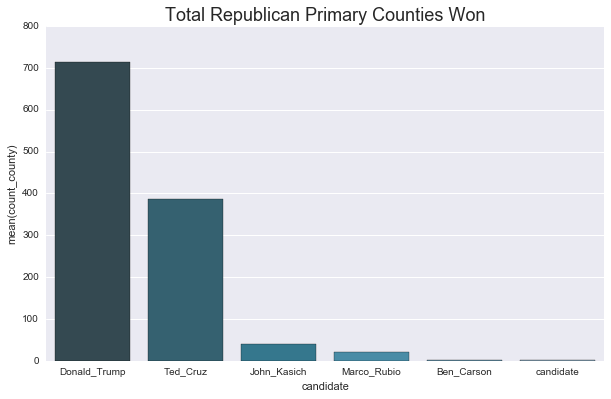

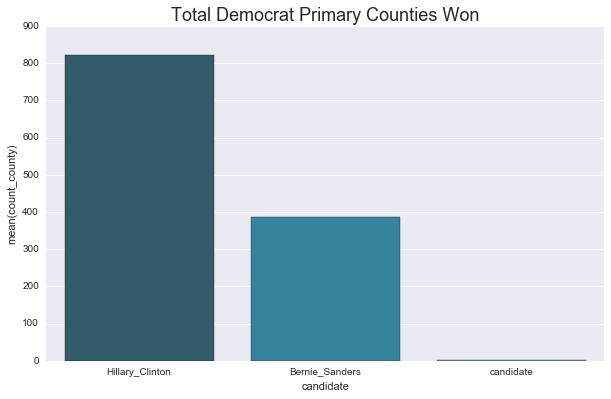

In [8]:
# republican winner by county:
rep_winner_county = pd.read_sql_query('SELECT candidate, count(candidate) as count_county FROM Republican_Winner GROUP BY candidate ORDER BY count_county desc', db)
# democrat winner by county:
dem_winner_county = pd.read_sql_query('SELECT candidate, count(candidate) as count_county FROM Democrat_Winner GROUP BY candidate ORDER BY count_county desc', db)

#plots
sns.plt.figure(figsize=(10,6))
sns.barplot(x = 'candidate', y = 'count_county', data = rep_winner_county, palette="PuBuGn_d")
sns.plt.title('Total Republican Primary Counties Won', fontsize = 18)

sns.plt.figure(figsize=(10,6))
sns.barplot(x = 'candidate', y = 'count_county', data = dem_winner_county, palette="PuBuGn_d")
sns.plt.title('Total Democrat Primary Counties Won', fontsize = 18)


## Preprocessing Data:

In [ ]:
#Identify the Republican winner in each county:
%sql SELECT state, state_abbreviation, county, fips, party, candidate, MAX(votes), fraction_votes, county_state FROM Republicans GROUP BY county ORDER BY state;
%sql CREATE TABLE Republican_Winner(state TEXT NOT NULL, state_abbreviation TEXT NOT NULL, county TEXT NOT NULL, fips INTEGER NOT NULL, party TEXT NOT NULL, candidate TEXT NOT NULL, votes INTEGER NOT NULL, fraction_votes INTEGER NOT NULL, county_state TEXT NOT NULL);
#.import republican_winners.csv Republican_Winner

#Identify the Democrat winner in each county:
%sql SELECT state, state_abbreviation, county, fips, party, candidate, MAX(votes), fraction_votes, county_state FROM Democrats GROUP BY county ORDER BY state;
%sql CREATE TABLE Democrat_Winner(state TEXT NOT NULL, state_abbreviation TEXT NOT NULL, county TEXT NOT NULL, fips INTEGER NOT NULL, party TEXT NOT NULL, candidate TEXT NOT NULL, votes INTEGER NOT NULL, fraction_votes INTEGER NOT NULL, county_state TEXT NOT NULL);
#.import democrat_winners.csv Democrat_Winner 

# Join Tables:
%sql SELECT * FROM Republican_Winner INNER JOIN county_facts WHERE Republican_Winner.county_state = county_facts.county_state;
%sql SELECT * FROM Democrat_Winner INNER JOIN county_facts WHERE Democrat_Winner.county_state = county_facts.county_state;

In [10]:
#Dataframe for Republican winners per county w/ county facts:
republican_data = pd.read_csv("republican_winners_county_facts.csv")
republican_data.drop(republican_data.columns[[1,9,10,11,63]], axis=1, inplace=True) #Drop repeated rows

#Dataframe for Democrat winners per county w/ county facts:
democrat_data = pd.read_csv("democrat_winners_county_facts.csv") 
democrat_data.drop(democrat_data.columns[[1,9,10,11,63]], axis=1, inplace=True) #Drop repeated rows

republican_data.head()

state   county  fips       party     candidate  votes  fraction_votes  \
0  Alabama  Autauga  1001  Republican  Donald_Trump   5387           0.445   
1  Alabama  Baldwin  1003  Republican  Donald_Trump  23618           0.469   
2  Alabama  Barbour  1005  Republican  Donald_Trump   1710           0.501   
3  Alabama  Bullock  1011  Republican  Donald_Trump    313           0.565   
4  Alabama  Calhoun  1015  Republican  Donald_Trump   8960           0.451   

  county_state  PST045214  PST040210    ...      SBO415207  SBO015207  \
0   Autauga_AL      55395      54571    ...            0.7       31.7   
1   Baldwin_AL     200111     182265    ...            1.3       27.3   
2   Barbour_AL      26887      27457    ...            0.0       27.0   
3   Bullock_AL      10764      10915    ...            0.0       38.8   
4   Calhoun_AL     115916     118586    ...            0.5       24.7   

   MAN450207  WTN220207  RTN130207  RTN131207  AFN120207  BPS030214  \
0          0          0     598175      12003      88157        131   
1    1410273          0    2966489      17166     436955       1384   
2          0          0     188337       6334          0          8   
3          0          0      43810       3995       3670          1   
4    2679991          0    1542981      13678     186533        114   

   LND110210  POP060210  
0     594.44       91.8  
1    1589.78      114.6  
2     884.88       31.0  
3     622.81       17.5  
4     605.87      195.7  

[5 rows x 59 columns]

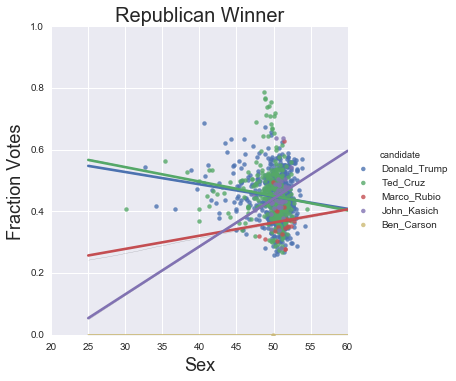

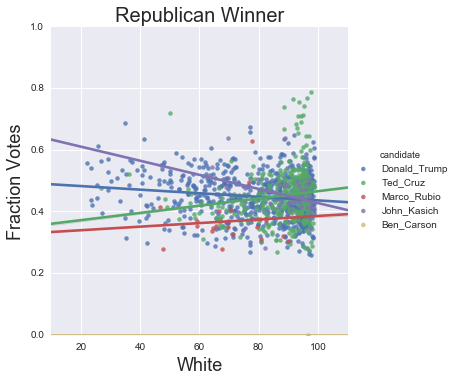

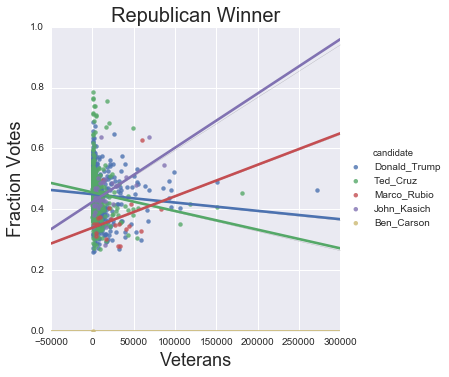

In [11]:
g = sns.lmplot(x="SEX255214", y = "fraction_votes", data = republican_data, hue = "candidate", ci=False)
g.set_xlabels("Sex", size = 18)
g.set_ylabels("Fraction Votes", size = 18)
g.set(xlim=(20,60), ylim=(0,1))
sns.plt.title('Republican Winner', fontsize = 20)

g = sns.lmplot(x="RHI125214", y = "fraction_votes", data = republican_data, hue = "candidate", ci=False)
g.set_xlabels("White", size = 18)
g.set_ylabels("Fraction Votes", size = 18)
g.set(ylim=(0,1))
sns.plt.title('Republican Winner', fontsize = 20)

g = sns.lmplot(x="VET605213", y = "fraction_votes", data = republican_data, hue = "candidate", ci=False)
g.set_xlabels("Veterans", size = 18)
g.set_ylabels("Fraction Votes", size = 18)
g.set(ylim=(0,1))
sns.plt.title('Republican Winner', fontsize = 20)


In [13]:
# Remove all candidates who suspended campaign:
to_del = republican_data.loc[republican_data['candidate'].isin(['Jeb_Bush', 'Ben_Carson','Rand_Paul','Chris_Christie','Carly_Fiorina','Rick_Santorum','Mike_Huckabee',"Marco_Rubio","_No_Preference","_Uncommitted"])].index.tolist()
republican_data = republican_data.drop(to_del)

# Arranging Data for Features & Targets
republican_data = republican_data.replace(['Donald_Trump','Ted_Cruz','John_Kasich'],[1,2,3])

x_vars = list(republican_data.columns[8:]) 
x_vars= republican_data[x_vars] # Features
y_vars = republican_data['candidate'] # Target Labels
df_rep = pd.concat([x_vars,y_vars],axis=1) #combine Feautres/Target into one dataframe

feature_cols = list(df_rep.columns[:-1])  # all columns but last are features
target_col = df_rep.columns[-1]  # last column is the target/label

X_all = df_rep[feature_cols]  # feature values 
y = df_rep[target_col]  # corresponding targets/labels

#print X_all
#print y

## Split Training/Testing Set

In [18]:
num_all = df_rep.shape[0]
num_train = int(num_all - (num_all*.25))
num_test = num_all - num_train

def Stratified_Shuffle_Split(X,y,num_test):
    sss = StratifiedShuffleSplit(y, 10, test_size=num_test, random_state = 42)
    for train_index, test_index in sss:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y, num_test)
print "Training Set: {0:.2f} Samples".format(X_train.shape[0])
print "Testing Set: {0:.2f} Samples".format(X_test.shape[0])


Training Set: 848.00 Samples
Testing Set: 283.00 Samples


## Principal Component Analysis

In [25]:
#correlation matrix
X_all.corr()

PST045214  PST040210  PST120214  POP010210  AGE135214  AGE295214  \
PST045214   1.000000   0.999396   0.308403   0.999395   0.117595   0.091121   
PST040210   0.999396   1.000000   0.298678   1.000000   0.115645   0.088471   
PST120214   0.308403   0.298678   1.000000   0.298669   0.269188   0.287189   
POP010210   0.999395   1.000000   0.298669   1.000000   0.115662   0.088493   
AGE135214   0.117595   0.115645   0.269188   0.115662   1.000000   0.881105   
AGE295214   0.091121   0.088471   0.287189   0.088493   0.881105   1.000000   
AGE775214  -0.213828  -0.212557  -0.370617  -0.212564  -0.666327  -0.669299   
SEX255214   0.128488   0.131974   0.009764   0.131961   0.100577   0.160901   
RHI125214  -0.114769  -0.117031   0.079138  -0.117021  -0.141458  -0.034379   
RHI225214   0.068531   0.071287  -0.126783   0.071275   0.096823  -0.009181   
RHI325214  -0.036140  -0.036536  -0.012827  -0.036532   0.105275   0.110598   
RHI425214   0.559850   0.555689   0.427374   0.555687   0.124867   0.096972   
RHI525214   0.125256   0.123683   0.206691   0.123690   0.253185   0.202328   
RHI625214   0.106155   0.106847   0.132660   0.106850   0.070725   0.045380   
RHI725214   0.136012   0.131761   0.232765   0.131776   0.448029   0.412955   
RHI825214  -0.191649  -0.190182  -0.112723  -0.190185  -0.456308  -0.345374   
POP715213  -0.195352  -0.194207  -0.302383  -0.194209  -0.237075  -0.036909   
POP645213   0.385056   0.380777   0.356407   0.380784   0.357297   0.326702   
POP815213   0.218808   0.215043   0.274024   0.215054   0.455138   0.425012   
EDU635213   0.162156   0.164229   0.233631   0.164211  -0.273188  -0.201076   
EDU685213   0.382536   0.381933   0.463685   0.381892  -0.068060  -0.055328   
VET605213   0.955706   0.958338   0.317143   0.958336   0.069659   0.033698   
LFE305213   0.045457   0.043761   0.082914   0.043752  -0.243710  -0.098525   
HSG010214   0.993991   0.995220   0.300077   0.995218   0.089013   0.053957   
HSG445213  -0.266094  -0.267663  -0.126649  -0.267677  -0.404669  -0.185602   
HSG096213   0.522349   0.526226   0.318144   0.526221   0.165952   0.025116   
HSG495213   0.215277   0.214484   0.418217   0.214446  -0.155330  -0.094364   
HSD410213   0.996261   0.997635   0.296883   0.997634   0.099573   0.067890   
HSD310213   0.105875   0.102080   0.321446   0.102103   0.619507   0.707824   
INC910213   0.274860   0.274168   0.423649   0.274131  -0.167270  -0.080393   
INC110213   0.224867   0.222003   0.520176   0.221982   0.032703   0.186023   
PVY020213  -0.086159  -0.084343  -0.332722  -0.084320   0.163818   0.022203   
BZA010213   0.984031   0.983713   0.299342   0.983715   0.099363   0.064826   
BZA110213   0.979154   0.978754   0.268704   0.978754   0.119096   0.080172   
BZA115213   0.044716   0.042585   0.143427   0.042589   0.022964   0.072957   
NES010213   0.984659   0.982437   0.307120   0.982438   0.104358   0.079977   
SBO001207   0.987555   0.986912   0.305652   0.986913   0.097961   0.071685   
SBO315207   0.207207   0.211535   0.049254   0.211514   0.125596   0.066849   
SBO115207   0.021483   0.021906   0.011855   0.021910   0.074065   0.067959   
SBO215207   0.593891   0.591486   0.370447   0.591494   0.157723   0.140058   
SBO515207   0.291892   0.293128   0.119415   0.293137   0.126496   0.106586   
SBO415207   0.264203   0.260811   0.261906   0.260821   0.294571   0.267649   
SBO015207   0.235314   0.238785   0.237490   0.238768   0.066091   0.056472   
MAN450207   0.794858   0.795355   0.159942   0.795329   0.093579   0.078123   
WTN220207   0.811199   0.806314   0.168885   0.806292   0.093612   0.075442   
RTN130207   0.984080   0.983532   0.291778   0.983535   0.107487   0.075452   
RTN131207   0.250896   0.252547   0.273553   0.252550   0.149116   0.073131   
AFN120207   0.736233   0.735484   0.205128   0.735492   0.068669   0.037501   
BPS030214   0.870839   0.857405   0.361664   0.857399   0.118620   0.099655   
LND110210   0.134922   0.134595   0.057750   0.134598   0.128

In [26]:
#covariance matrix
cov_matrix = republican_data.cov()
cov_matrix

fips      candidate         votes  fraction_votes  \
fips            2.295939e+08    3005.543325 -7.670364e+06       40.188670   
candidate       3.005543e+03       0.311027  7.073274e+02        0.000971   
votes          -7.670364e+06     707.327386  1.355982e+08      -10.560899   
fraction_votes  4.018867e+01       0.000971 -1.056090e+01        0.005826   
PST045214      -1.016955e+08    8660.356899  2.918684e+09    -1527.279993   
PST040210      -1.096253e+08    8014.554883  2.749175e+09    -1447.243458   
PST120214       6.824555e+03       0.374440  1.663477e+04       -0.029611   
POP010210      -1.096899e+08    8015.293294  2.749031e+09    -1446.526849   
AGE135214       8.343055e+02       0.176387  7.423314e+02        0.009448   
AGE295214       4.213743e+03       0.599220  1.753849e+03        0.032235   
AGE775214      -2.609780e+03      -0.471538 -8.319686e+03        0.019530   
SEX255214      -3.952149e+03      -0.079295  4.353760e+03       -0.022771   
RHI125214       3.735586e+04       2.124773 -1.286329e+04       -0.067720   
RHI225214      -3.881131e+04      -2.333434  6.177247e+03        0.104350   
RHI325214       8.799459e+02       0.064709 -3.408555e+03       -0.003382   
RHI425214      -5.776502e+02       0.069920  8.676522e+03       -0.018148   
RHI525214      -1.077917e+02       0.004575  1.584890e+02        0.000919   
RHI625214       1.248480e+03       0.069080  1.257863e+03       -0.015950   
RHI725214       7.245152e+04       2.844332  1.003491e+04        0.052460   
RHI825214      -3.321958e+04      -0.622961 -2.147371e+04       -0.114357   
POP715213       3.909670e+03      -0.276927 -9.029045e+03        0.030399   
POP645213       1.039718e+04       0.540868  1.927015e+04       -0.005000   
POP815213       4.695982e+04       1.996665  2.021603e+04        0.012651   
EDU635213      -6.876372e+03       0.444747  2.095067e+04       -0.149083   
EDU685213       6.060331e+03       0.746270  4.000828e+04       -0.183063   
VET605213      -1.772294e+07     211.755526  1.792569e+08      -88.590617   
LFE305213       8.388222e+02      -0.738343  3.724073e+03        0.029208   
HSG010214      -7.340465e+07    2661.305537  1.209511e+09     -610.164782   
HSG445213       1.069185e+04      -0.160035 -1.725420e+04        0.033495   
HSG096213      -1.446122e+04       0.423000  4.673212e+04       -0.125061   
HSG495213       3.814537e+07   -1337.940972  1.561788e+08     -534.322041   
HSD410213      -5.047672e+07    2901.045997  1.028766e+09     -567.034108   
HSD310213       4.024204e+02       0.022670  1.507593e+02        0.003551   
INC910213       1.003549e+07     465.346781  1.933472e+07     -100.666743   
INC110213       3.007723e+07    1373.329028  3.533602e+07     -158.074673   
PVY020213      -1.729835e+04      -0.782103 -1.198509e+04        0.090905   
BZA010213      -3.296825e+06     190.088770  6.712036e+07      -36.695442   
BZA110213      -1.437399e+07    4900.991840  1.182116e+09     -723.209617   
BZA115213       2.757519e+03       0.274856  3.223930e+03        0.029342   
NES010213      -7.241402e+06     581.202112  2.257054e+08     -118.940962   
SBO001207      -1.098413e+07     640.201437  2.487750e+08     -132.847519   
SBO315207      -1.247626e+04      -0.602146  1.479840e+04       -0.018366   
SBO115207       6.626284e+02       0.023139 -5.582722e+01       -0.010630   
SBO215207      -1.704608e+03       0.002187  9.791816e+03       -0.016850   
SBO515207       1.046900e+01       0.000007  6.874565e+01        0.000191   
SBO415207       1.179665e+04       0.458809  1.650384e+04       -0.033278   
SBO015207      -2.318171e+04      -0.537658  3.761249e+04       -0.164989   
MAN450207       2.610268e+09  330541.969023  5.387612e+10   -37907.292147   
WTN220207       1.834622e+09  211298.947530  5.822466e+10   -30385.755096   
RTN130207      -2.111071e+09   96724.177975  3.874912e+10   -20896.898427   
RTN131207      -5.195242e+06     107.517337  1.624012e+07      -67.485782   
AFN120207      -3.32

In [27]:
#Eigenvalue and Eigenvector of covariance matrix:
columns = X_all.columns
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)
sum_ev = sum(eig_vals)
#Explained Variance Ratio
print eig_vals/sum_ev

[  9.12426422e-01   5.05808687e-02   3.35054847e-02   3.40696829e-03
   4.64645391e-05   2.52804790e-05   3.35026015e-06   2.19092190e-06
   1.27321704e-06   5.70581463e-07   4.34066159e-07   2.28306781e-07
   1.60910363e-07   1.36672461e-07   6.12940850e-08   4.51161834e-08
   3.48733645e-08   1.68277173e-08   5.80415831e-09   1.42785761e-09
   9.83343947e-10   2.33204107e-10   2.09414471e-10   5.66812323e-12
   3.94545154e-12   1.13027617e-12   6.22986160e-13   3.75338827e-13
   3.06657141e-13   2.55425411e-13   2.36627963e-13   1.87936219e-13
   1.37018421e-13   1.20406777e-13   1.01891968e-13   9.33780155e-14
   8.51660826e-14   6.50577571e-14   5.39639250e-14   4.92736143e-14
   4.31923866e-14   3.36914509e-14   1.38800054e-14   1.44115839e-14
   1.12553579e-14   6.13427581e-15   3.84143816e-15   1.63684437e-15
   1.52835551e-15   6.98048033e-16   2.26200089e-16   1.12160875e-16
   3.40166707e-17   4.97341762e-18   7.77095532e-18]


In [28]:
#Standardize features by removing the mean and scaling to unit variance
columns = X_all.columns
scale = preprocessing.scale(X_all)
df_scale = pd.DataFrame(scale, columns=columns)
#df_scale

In [29]:
def doPCA():
    pca = PCA(n_components=5)
    pca.fit(df_scale)
    return pca

# Print the components and the amount of variance in the data contained in each dimension
pca = doPCA()
columns = X_all.columns
df_pca = pd.DataFrame(pca.components_, columns = columns, index=['1', '2', '3', '4','5'])
df_pca.index.names = ['PC']
print "Principal Component Analysis:"
print df_pca

ex_var = pca.explained_variance_ratio_
df_var = pd.Series(ex_var,index=['1','2','3','4','5'])
df_var.sort(ascending=False)

df_var.index.names = ['PC']
print "\nExplained Variance of Each Component:"
print df_var

Principal Component Analysis:
    PST045214  PST040210  PST120214  POP010210  AGE135214  AGE295214  \
PC                                                                     
1    0.235864   0.235609   0.103282   0.235607   0.048712   0.039361   
2   -0.009313  -0.010187  -0.007516  -0.010175   0.268182   0.224758   
3   -0.080234  -0.082502   0.270142  -0.082504   0.172104   0.207872   
4   -0.072751  -0.070048   0.048630  -0.070056   0.079457   0.015741   
5   -0.016831  -0.016959   0.030667  -0.016965  -0.020467  -0.006958   

    AGE775214  SEX255214  RHI125214  RHI225214    ...      SBO415207  \
PC                                                ...                  
1   -0.078142   0.036262  -0.035424   0.021251    ...       0.074254   
2   -0.177321  -0.067104  -0.148789   0.136233    ...       0.196845   
3   -0.175864  -0.041826   0.200798  -0.227332    ...       0.131743   
4   -0.180330   0.141715  -0.352034   0.334968    ...      -0.133396   
5   -0.028238   0.064830   0.0390

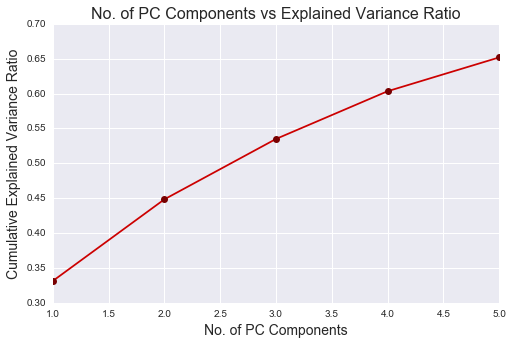

In [30]:
pl.figure(figsize=(8,5))
x = np.arange(1,6) # Number of PC's
y= np.cumsum(ex_var)# cumulative sum of explained variance
pl.plot(x,y,marker ="o", mfc='#780000', color = '#CC0000')
pl.xlabel("No. of PC Components", fontsize = 14)
pl.ylabel("Cumulative Explained Variance Ratio", fontsize =14)
pl.title("No. of PC Components vs Explained Variance Ratio", fontsize = 16)
pl.show()

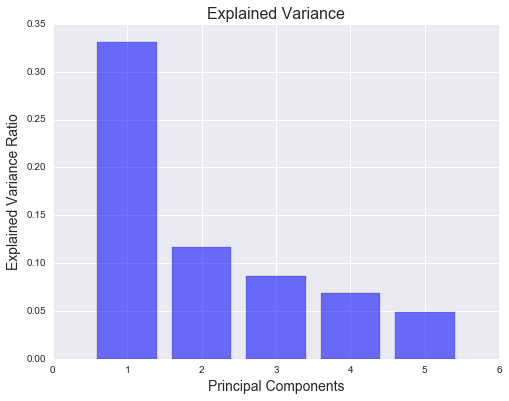

Slope1: -0.844231
Slope2: -0.019584
Slope3: -0.03452


In [31]:
pl.figure(figsize=(8,6))
pl.bar(range(1,6),ex_var, alpha=.55, align='center', label='Individual Explained Variance', color = 'b')
pl.ylabel('Explained Variance Ratio', fontsize = 14)
pl.xlabel('Principal Components', fontsize  =14)
pl.title('Explained Variance', fontsize = 16)
pl.show()

#Slope:
X1, Y1 = 1, 0.901574
X2, Y2 = 2, 0.057343
X3, Y3 = 3, 0.037759
X4, Y4 = 4, 0.003239
X5, Y5 = 5, 0.000049
slope1 = (Y2-Y1)/(X2-X1)
slope2 = (Y3-Y2)/(X3-X2)
slope3= (Y4-Y3)/(X4-X3)
print "Slope1:", slope1
print "Slope2:", slope2
print "Slope3:", slope3

In [19]:
def train_classifier(clf, X_train, y_train):
    print "Training {}:".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    train_clf_time = end - start
    print "Training Time (secs): {:.3f}".format(train_clf_time)
    return train_clf_time

def predict_labels(clf, features, target):
    print "Predicting labels using {}:".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    prediction_time = end - start
    print "Prediction Time (secs): {:.3f}".format(prediction_time)
    return (f1_score(target.values, y_pred, pos_label= None, average = 'weighted'), prediction_time)

# Train and Predict
def train_predict(clf, X_train, y_train, X_test, y_test):
    print "------------------------------------------"
    print "Training set size: {}".format(len(X_train))
    print "Testing set size: {}".format(len(X_test))
    train_diff = train_classifier(clf, X_train, y_train)
    
    # Train and predict on diff. training set sizes
    f1_score_train, pred_time_train = predict_labels(clf, X_train, y_train)
    print "F1 score for training set:",(f1_score_train)
    # Predict on test data
    f1_score_test, pred_time_test = predict_labels(clf, X_test, y_test)
    print "F1 score for test set:",(f1_score_test)
    
    return (f1_score_train, f1_score_test, train_diff, pred_time_test)


In [20]:
clf_RF = RandomForestClassifier(n_estimators=10)

def run_all_models(classifiers):
    for clf in classifiers:
        df = pd.DataFrame(columns = [
                    'Training_Size',
                    'Testing_Size',
                    'Training_Time',
                    'Prediction_Time',
                    'F1_Training_Score',
                    'F1_Testing_Score'])

        X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y, num_test)
        
        num_times_to_run = 10
        sizes = [X_test.shape[0]]
        for size in sizes: 
            for x in range(0, num_times_to_run): 
                f1_score_train, f1_score_test, train_time, pred_time_test = train_predict(clf, X_train[:size], y_train[:size], X_test, y_test)
                        
                df = df.append({
                        'Training_Size': len(X_train[:size]),
                        'Testing_Size': X_test.shape[0],
                        'Training_Time': train_time,
                        'Prediction_Time': pred_time_test,
                        'F1_Training_Score': f1_score_train,
                        'F1_Testing_Score': f1_score_test}, 
                        ignore_index= True)
            
            df = df[(df.Training_Size == size)]
            df_mean = df.mean()
        
            print "**********************************************************"
            print "Mean Statistics:"
            print df_mean
            print "**********************************************************"

In [21]:
run_all_models([clf_RF])

------------------------------------------
Training set size: 283
Testing set size: 283
Training RandomForestClassifier:
Training Time (secs): 0.052
Predicting labels using RandomForestClassifier:
Prediction Time (secs): 0.003
F1 score for training set: 1.0
Predicting labels using RandomForestClassifier:
Prediction Time (secs): 0.002
F1 score for test set: 0.753590439887
------------------------------------------
Training set size: 283
Testing set size: 283
Training RandomForestClassifier:
Training Time (secs): 0.051
Predicting labels using RandomForestClassifier:
Prediction Time (secs): 0.003
F1 score for training set: 0.985800486267
Predicting labels using RandomForestClassifier:
Prediction Time (secs): 0.002
F1 score for test set: 0.75393952749
------------------------------------------
Training set size: 283
Testing set size: 283
Training RandomForestClassifier:
Training Time (secs): 0.045
Predicting labels using RandomForestClassifier:
Prediction Time (secs): 0.002
F1 score for tr

## Fine Tune Model:

In [22]:
def iterate_fit_predict(number_runs):
    f1_scores = []
    
    for num in range(0, number_runs):
        X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y, num_test)
        clf = clf_RF
        parameters = {'max_depth':(1,2,3,4,5,6,7,8,9,10)}
        
        clf = GridSearchCV(clf_RF, parameters, scoring = 'f1')
        
        #Fit classifier to training data:
        clf.fit(X_train,y_train)
        f1_scores.append(clf.score(X_test,y_test))
        #clf = clf.best_estimator_
    
    df_f1 = pd.Series(f1_scores)
    print clf
    print "\nF1 Scores:"
    print df_f1
    
    print "\n Average F1 Test Scores:"
    print df_f1.mean()
        

In [24]:
iterate_fit_predict(10)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

F1 Scores:
0    0.776123
1    0.766987
2    0.784522
3    0.782732
4    0.789320
5    0.772280
6    0.770958
7    0.766208
8    0.762992
9    0.763151
dtype: float64

 Average F1 Test Scores:
0.773527311988
